## Modeling for multiple movies
We would like to see how our models are performing on multiple movies

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import datetime
# pd.set_option('display.max_colwidth',10000)
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.neighbors import KNeighborsClassifier
import gensim
import spacy

In [3]:
movie_cleaned = pd.read_csv('../IMDB/movie_cleaned.csv')
review_cleaned = pd.read_csv('../IMDB/review_cleaned.csv')
movie_title_cleaned = pd.read_csv('../IMDB/movie_titles_cleaned.csv')
data = pd.merge(review_cleaned, movie_cleaned, on='movie_id')
df = pd.merge(data, movie_title_cleaned, on='movie_id')

### Extracting top 5 movies from the same genre (with the highest number of spoiler reviews)

In [4]:
list_movies_genre = list(df['genre'].value_counts()[:1].index)
many_movies_genre = df[df['genre'].isin(list_movies_genre)]

In [5]:
list_movies = list(many_movies_genre['movie_title'].value_counts()[1:6].index)
many_movies = many_movies_genre[many_movies_genre['movie_title'].isin(list_movies)]

In [6]:
many_movies.shape

(3699, 15)

In [41]:
many_movies['is_spoiler'].value_counts()

0    2483
1    1216
Name: is_spoiler, dtype: int64

In [42]:
X_many = many_movies[['review']]
y_many = many_movies['is_spoiler']

In [43]:
X_many_train, X_many_test, y_many_train, y_many_test = train_test_split(X_many, y_many, stratify=y_many)

In [44]:
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def review_to_words(reviews):
        
    letters_only = re.sub("[^a-zA-Z]", " ", reviews)
    
    words = letters_only.lower().split()
    
    stops = all_stopwords
    meaningful_words = [w for w in words if not w in stops]

    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]

    return(" ".join(tokens_lem))

In [45]:
X_many_train_cleaned = []
X_many_test_cleaned = []
total_reviews = many_movies.shape[0]
print(f'There are {total_reviews} posts.')

There are 3699 posts.


In [46]:
print("Cleaning and parsing the training set reviews...")

j = 0
for reviews in X_many_train['review']:
    X_many_train_cleaned.append(review_to_words(reviews))
#     clean_train_posts[X_train] = review_to_words(train_post)
                                                  
    if (j + 1) % 100 == 0:
        print(f'Posts {j + 1} of {total_reviews}.')
    
    j += 1
    
print("Cleaning and parsing the training set reviews...")

j = 0
for reviews in X_many_test['review']:
    X_many_test_cleaned.append(review_to_words(reviews))
#     clean_train_posts[X_train] = review_to_words(train_post)
                                                  
    if (j + 1) % 100 == 0:
        print(f'Posts {j + 1} of {total_reviews}.')
    
    j += 1

Cleaning and parsing the training set reviews...
Posts 100 of 3699.
Posts 200 of 3699.
Posts 300 of 3699.
Posts 400 of 3699.
Posts 500 of 3699.
Posts 600 of 3699.
Posts 700 of 3699.
Posts 800 of 3699.
Posts 900 of 3699.
Posts 1000 of 3699.
Posts 1100 of 3699.
Posts 1200 of 3699.
Posts 1300 of 3699.
Posts 1400 of 3699.
Posts 1500 of 3699.
Posts 1600 of 3699.
Posts 1700 of 3699.
Posts 1800 of 3699.
Posts 1900 of 3699.
Posts 2000 of 3699.
Posts 2100 of 3699.
Posts 2200 of 3699.
Posts 2300 of 3699.
Posts 2400 of 3699.
Posts 2500 of 3699.
Posts 2600 of 3699.
Posts 2700 of 3699.
Cleaning and parsing the training set reviews...
Posts 100 of 3699.
Posts 200 of 3699.
Posts 300 of 3699.
Posts 400 of 3699.
Posts 500 of 3699.
Posts 600 of 3699.
Posts 700 of 3699.
Posts 800 of 3699.
Posts 900 of 3699.


There are 2443717 words in the combination of all spoiler reviews.


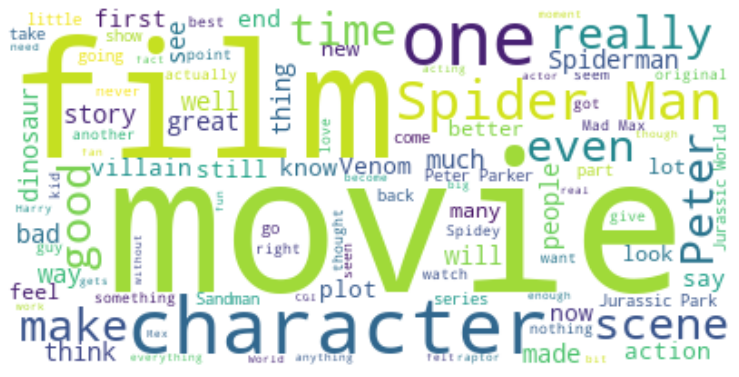

In [47]:
spoiler = " ".join(posts for posts in many_movies[many_movies['is_spoiler']==1]['review'])
print ("There are {} words in the combination of all spoiler reviews.".format(len(spoiler)))

wordcloud_spoiler = WordCloud(stopwords=set(STOPWORDS), background_color="white", max_words=100).generate(spoiler)

plt.figure(figsize=[13,10])
plt.imshow(wordcloud_spoiler, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 3632633 words in the combination of all non-spoiler reviews.


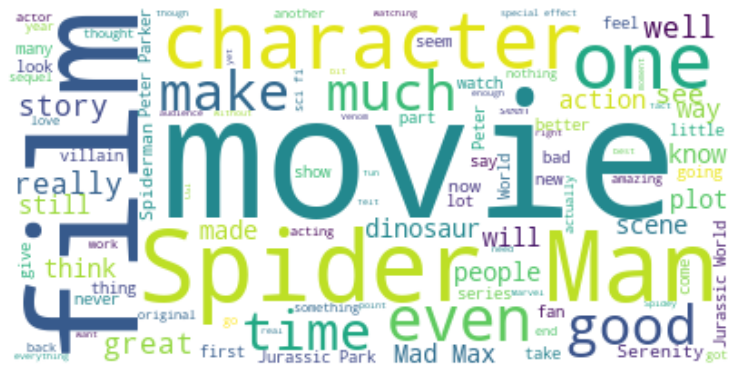

In [48]:
no_spoiler = " ".join(posts for posts in many_movies[many_movies['is_spoiler']==0]['review'])
print ("There are {} words in the combination of all non-spoiler reviews.".format(len(no_spoiler)))

wordcloud_no_spoiler = WordCloud(stopwords=set(STOPWORDS), background_color="white", max_words=100).generate(no_spoiler)

plt.figure(figsize=[13,10])
plt.imshow(wordcloud_no_spoiler, interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
def get_top_n_words(corpus, n=30):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def find_common_words(data):
    list_of_common_words = get_top_n_words(data)
    common_words = []
    for word, freq in list_of_common_words:
        common_words.append(word)
    return common_words


In [68]:
def confusion_table(test_y, pred_y):
    tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
    cm = pd.DataFrame(columns=['Predicted Negative','Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    cm['Predicted Positive'][1] = tp
    cm['Predicted Positive'][0] = fp
    cm['Predicted Negative'][1] = fn
    cm['Predicted Negative'][0] = tn
    
    print("True Negatives: %s" % tn)
    print("False Negatives: %s" % fn)
    print("False Positives: %s" % fp)
    print("True Positives: %s" % tp)
    return cm

def class_report(pred_y, test_y = 'y_one_train'):
    report = pd.DataFrame(classification_report(test_y, pred_y, output_dict=True))
    return report.T

In [58]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
stopWords.extend(find_common_words(X_many['review']))

In [57]:
find_common_words(X_many['review'])


['movie',
 'film',
 'man',
 'like',
 'just',
 'spider',
 'good',
 'action',
 'really',
 'story',
 'great',
 'time',
 'peter',
 'characters',
 'character',
 'jurassic',
 'movies',
 'park',
 'world',
 'max',
 'spiderman',
 'don',
 'best',
 'people',
 'bad',
 'did',
 'new',
 'way',
 'make',
 'plot']

### Naive Bayes (Multinomial) with CountVectorizer 

In [59]:
cvec = CountVectorizer(stop_words=stopWords, max_df = 0.9, max_features = 700, 
                             min_df = 4, ngram_range = (1, 2))
mnb = MultinomialNB()

In [61]:
X_many_train_cvec = cvec.fit_transform(X_many_train_cleaned)
X_many_test_cvec = cvec.transform(X_many_test_cleaned)

In [62]:
mnb.fit(X_many_train_cvec, y_many_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [115]:
print(f'Train accuracy score: {round(mnb.score(X_many_train_cvec, y_many_train)*100,4)}%')
print(f'Test accuracy score: {round(mnb.score(X_many_test_cvec, y_many_test)*100,4)}%')

Train accuracy score: 72.062%
Test accuracy score: 68.5405%


In [64]:
y_many_cpredict = mnb.predict(X_many_test_cvec)

In [67]:
confusion_table(y_many_test, y_many_cpredict)

True Negatives: 454
False Negatives: 124
False Positives: 167
True Positives: 180


,Predicted Negative,Predicted Positive
Actual Negative,454,167
Actual Positive,124,180


In [71]:
class_report(y_many_cpredict,y_many_test)

,precision,recall,f1-score,support
0,0.785467,0.731079,0.757298,621.000000
1,0.518732,0.592105,0.552995,304.000000
accuracy,0.685405,0.685405,0.685405,0.685405
macro avg,0.652100,0.661592,0.655147,925.000000
weighted avg,0.697805,0.685405,0.690154,925.000000


In [73]:
train_df = pd.DataFrame(X_many_train_cvec.todense(), columns=cvec.get_feature_names(), index=X_many_train.index)
test_df =  pd.DataFrame(X_many_test_cvec.todense(), columns=cvec.get_feature_names(), index=X_many_test.index)

In [76]:
pred_proba = [i[1] for i in mnb.predict_proba(test_df)]
pred_df = pd.DataFrame({'true_values': y_many_test,'pred_probs':pred_proba})

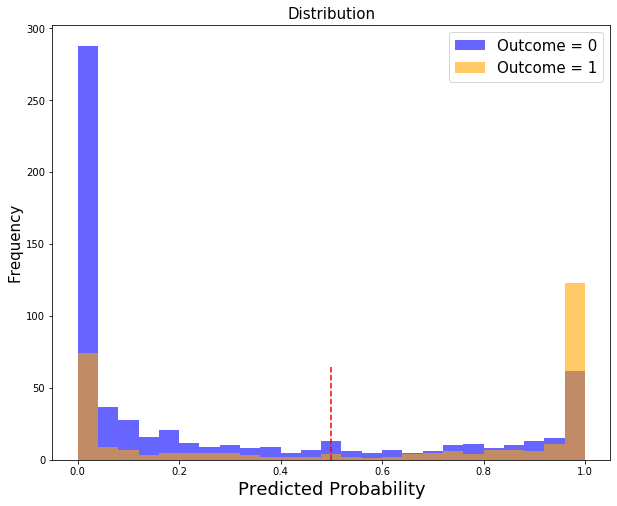

In [77]:
plt.figure(figsize = (10,8))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

plt.vlines(x=0.5, ymin = 0, ymax = 65, color='r', linestyle = '--')

plt.title('Distribution', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Predicted Probability', fontsize=18)

plt.legend(fontsize=15);

In [78]:
columns=cvec.get_feature_names()
mnb_coef = pd.DataFrame(mnb.coef_, columns = columns)
df_coef = mnb_coef.T.sort_values(by = 0, ascending = True)
df_coef


,0
visual effect,-8.254173
delivers,-8.107569
science fiction,-8.020558
buffy,-8.020558
trek,-7.979736
...,...
know,-5.098293
end,-5.037405
thing,-4.806695
dinosaur,-4.686867


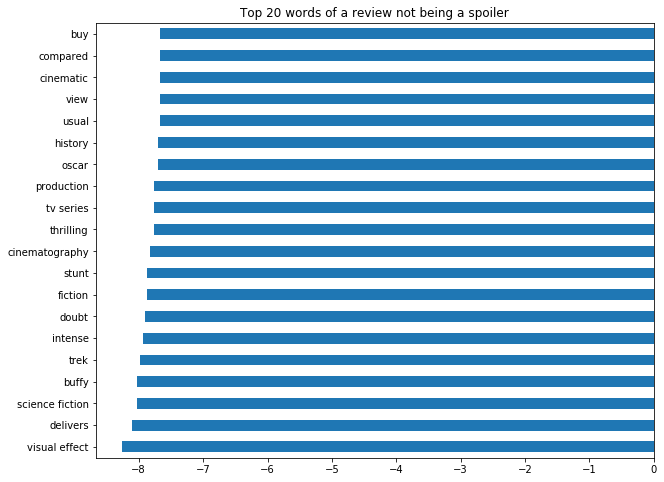

In [79]:
df_coef.head(20).plot(kind='barh', legend=False, figsize=(10,8))
plt.title('Top 20 words of a review not being a spoiler');

#### Words for non-spoiler reviews
- Most of the words that contributes to being a spoiler seems like they were describing how the movie was made (spvisual  effects etc) and how the generally felt about the movie (intense, thrilling etc)

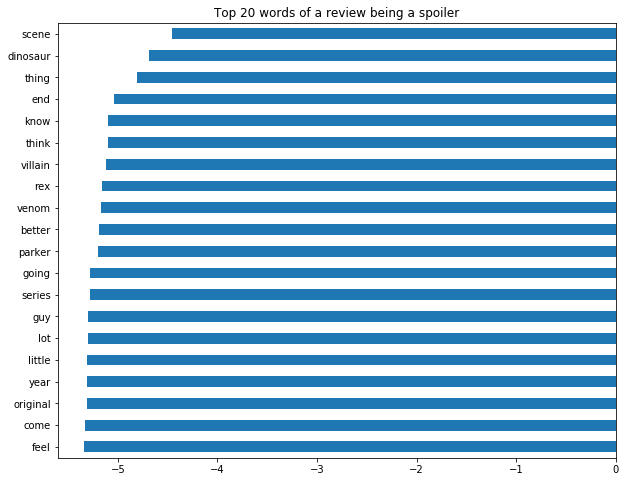

In [95]:
df_coef.tail(20).plot(kind='barh', legend=False, figsize=(10,8))
plt.title('Top 20 words of a review being a spoiler');

#### Words for spoiler reviews
- Most of the words seems like to be talking about how they felt about the movie (feel, know, think etc) 
- The reviews might have mentioned about the ending of the movie because of the word - end

### Looking at the wrongly classified reviews 

In [102]:
pred_df = pd.DataFrame(y_many_cpredict, columns=['predictions'], index=y_many_test.index)
y_many_test_df = pd.DataFrame(y_many_test.values, columns=['true_y_values'], index=y_many_test.index)

In [103]:
comparison_df = pd.merge(y_many_test,pred_df, on=y_many_test_df.index)
comparison_df.drop(columns='key_0', inplace=True)
comparison_df.set_index(X_many_test.index, inplace=True)

In [106]:
comparison_df[comparison_df['is_spoiler'] != comparison_df['predictions']]

,is_spoiler,predictions
71001,1,0
382002,0,1
189328,0,1
230128,1,0
230638,0,1
...,...,...
335700,1,0
189439,0,1
381806,0,1
382004,0,1


In [113]:
df.iloc[382002]

Unnamed: 0                                                   382002
review_date                                              2007-05-06
movie_id                                                  tt0413300
user_id                                                   ur6854519
is_spoiler                                                        0
review_text       Here's an easy analogy: Spider-Man 3 is the Sp...
user_rating                                                       4
review_summary             More of the same would have been better.
plot_summary      Peter Parker has finally managed to piece toge...
duration                                                   2h 19min
genre                             ['Action', 'Adventure', 'Sci-Fi']
movie_rating                                                    6.2
release_date                                             2007-05-04
plot_synopsis     Months after the events of Spider-Man 2, Peter...
movie_title                                     

In [114]:
X_many['review'][382002]

'More of the same would have been better.Here\'s an easy analogy: Spider-Man 3 is the Spider-Man 1 and 2 as Batman Forever is to Batman and Batman Returns. The third film in both series takes an entirely different approach towards entertainment than the first two did. Rather than sticking to the proved formula that made both Spider-Man 1 and 2 such well-critiqued superhero movies, Sam Raimi has turned Spider-Man 3 into a movie that has no idea what it wants to be.It tries too hard to be melodramatic, with some of the most clichéd, expected, and cringingly bad dialogue I\'ve ever heard in a movie. The first two Spidey films had a few moments like this, but the third in the series is almost full non-stop with these scenes that make you want to change the channel and find something better on.When the movie isn\'t being too melodramatic, however, it\'s trying to be freakishly campy. The first two films managed to include quite a bit of camp without completely suspending reality, but Spidey

### Conclusion
- Same problem happened where we cannot determine why some reviews were classified as spoilers/ non-spoilers originally after looking at the misclassfied reviews.